# PA005: High Value Customer Identification

# 0.0. Planning 

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0. Imports

In [1]:
import re
import os
import itertools
import joblib
import numpy   as np
import pandas  as pd
import seaborn as sns


import umap.umap_ as umap

from matplotlib import pyplot as plt

from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import ensemble      as en
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold      as mn
from sklearn import mixture       as mx
from pathlib import Path

from plotly import express as px
from scipy.cluster import hierarchy as hc
from sqlalchemy import create_engine

from sklearn.neighbors import NearestNeighbors

from IPython.display import display, HTML

C:\Users\nerod\anaconda3\envs\clusterizacao\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [4]:
# Define o caminho relativo
path = Path("../data/")

# Lê o arquivo CSV
df_raw = pd.read_csv(path / "Ecommerce.csv", encoding="latin1")

# Drop extra column
df_raw = df_raw.drop(columns=["Unnamed: 8"], axis=1)

# <font color='red'> 1.0. Descrição dos dados </font>

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Rename columuns

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [8]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [11]:
# Precisamos resolver o problema do NA

In [12]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [13]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [14]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [15]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [16]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.7. Descriptive Statistics

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributs

In [18]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097


### 1.7.2. Categorical Attributs

#### Invoice No

In [19]:
# problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype( int )

# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock Code

In [20]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

# <font color='red'> 2.0. Filtragem de Variáveis </font>

In [21]:
df2 = df1.copy()

In [22]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

In [23]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

In [24]:
df2_purchases.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


# <font color='red'> 3.0. Feature Engineering </font>

In [25]:
df3 = df2.copy()

## 3.1. Feature Creation

In [26]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [27]:
df_ref.shape

(5786, 1)

In [28]:
df_ref.isna().sum()

customer_id    0
dtype: int64

### 3.1.1. Gross Revenue

In [29]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

C:\Users\nerod\AppData\Local\Temp\ipykernel_21352\206990356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

In [30]:
df2_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Index: 527411 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   invoice_no     527411 non-null  object        
 1   stock_code     527411 non-null  object        
 2   quantity       527411 non-null  int64         
 3   invoice_date   527411 non-null  datetime64[ns]
 4   unit_price     527411 non-null  float64       
 5   country        527411 non-null  object        
 6   customer_id    527411 non-null  int32         
 7   gross_revenue  527411 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(3)
memory usage: 34.2+ MB


### 3.1.2. Recency - Day from last purchase

In [31]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Quantity of purchased

In [32]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4. Quantity total of items purchased  df 

In [33]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### 3.1.5. Quantity of products purchased  df

In [34]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### 3.1.6. Average Ticket Value 

In [35]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.7. Average Recency Days 

In [36]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.8. Frequency Purchase 

In [37]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.9. Number of Returns 

In [38]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.1.9. Basket Size - Quantidade de Items por Cesta ( Quantity ) df

In [39]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.2.0. Unique Basket Size - Quantidade de produtos distintos por compra df

In [40]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [41]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

In [42]:
len( df4['customer_id'].unique() )

2968

## 4.1. Univariate Analysis

**Metricas para avaliar**
1. Clusters Coesos - Separados
2. Métricas
    - Min, Máximo, Range ( Dispersão )
    - Média e Mediana
    - Desvio Padrão e Variância.
    - Coeficiente de Variação ( CV )
    - Distribuição

In [43]:
#profile = ProfileReport( df4 )
#profile.to_file( 'output_v3.html' )

## 4.2. Bivariate Analysis

In [44]:
cols = ['customer_id']
df42 = df4.drop( cols, axis=1 )

In [45]:
#plt.figure( figsize=(25, 12) )
#sns.pairplot( df42 )

## 4.3. Estudo do Espaço

In [46]:
# selected dataset
#cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
#df43 = df4[ cols_selected ].drop( columns='customer_id', axis=1 )

cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[ cols_selected ].copy()

In [47]:
mm1 = pp.MinMaxScaler()
mm2 = pp.MinMaxScaler()
mm3 = pp.MinMaxScaler()
mm4 = pp.MinMaxScaler()
mm5 = pp.MinMaxScaler()

df43['gross_revenue'] = mm1.fit_transform( df43[['gross_revenue']] )
df43['recency_days']  = mm2.fit_transform( df43[['recency_days']] )
df43['qtde_products'] = mm3.fit_transform( df43[['qtde_products']])
df43['frequency']     = mm4.fit_transform( df43[['frequency']])
df43['qtde_returns']  = mm5.fit_transform( df43[['qtde_returns']])

#X = df43.copy()

In [48]:
X = df43.drop( columns='customer_id', axis=1 )

In [49]:
X.shape

(2968, 5)

### 4.3.1. PCA

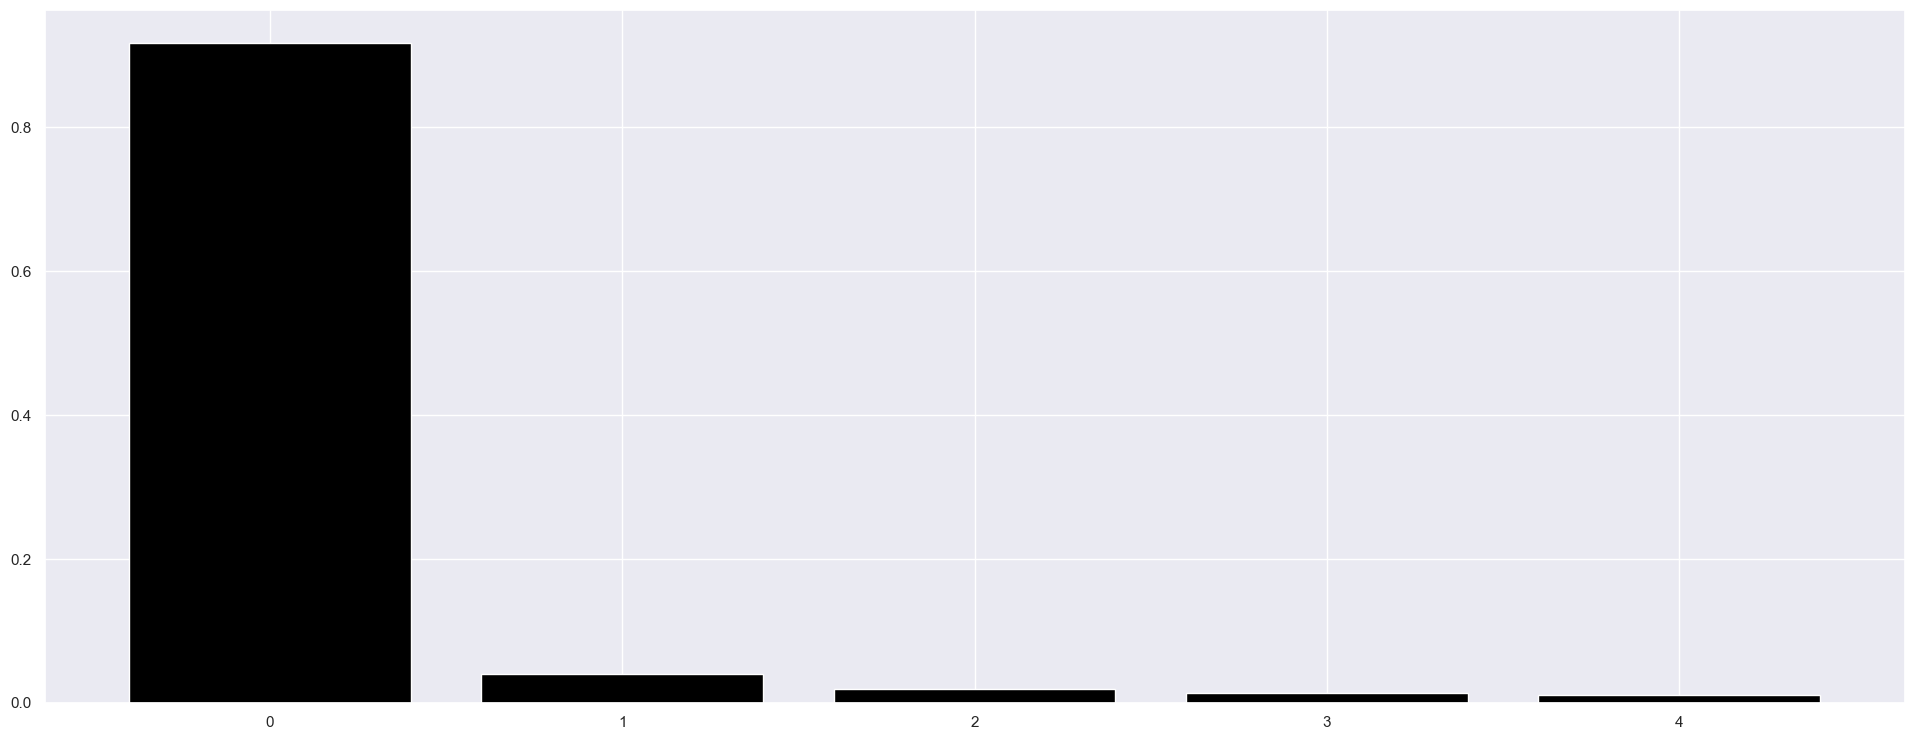

In [50]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<Axes: xlabel='0', ylabel='1'>

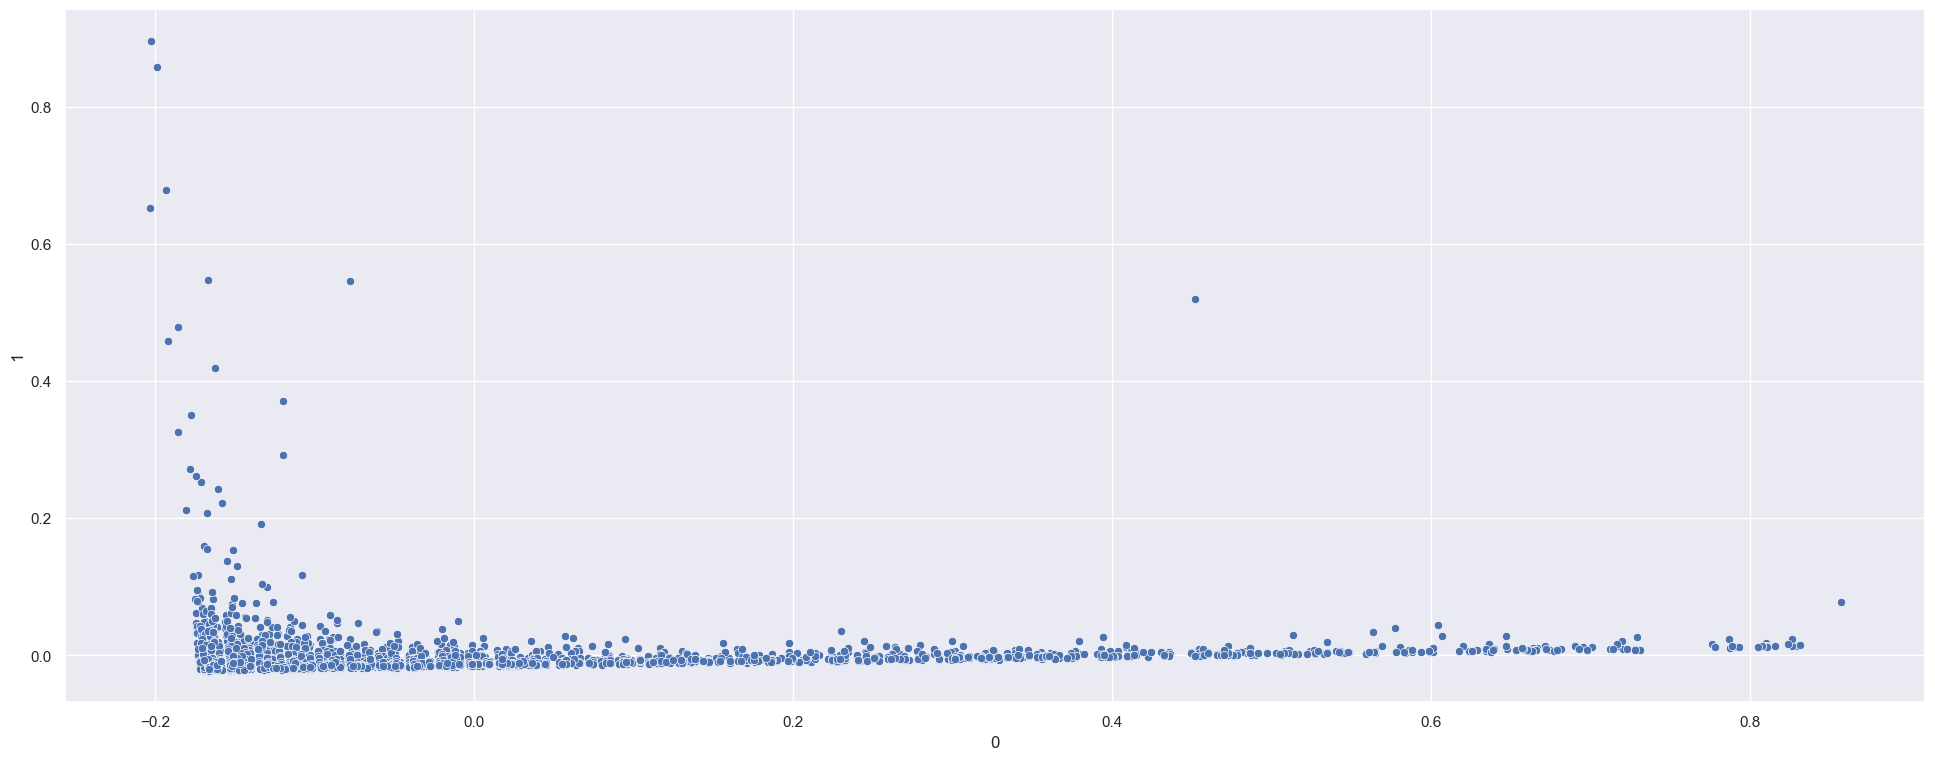

In [51]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2. UMAP

C:\Users\nerod\anaconda3\envs\clusterizacao\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

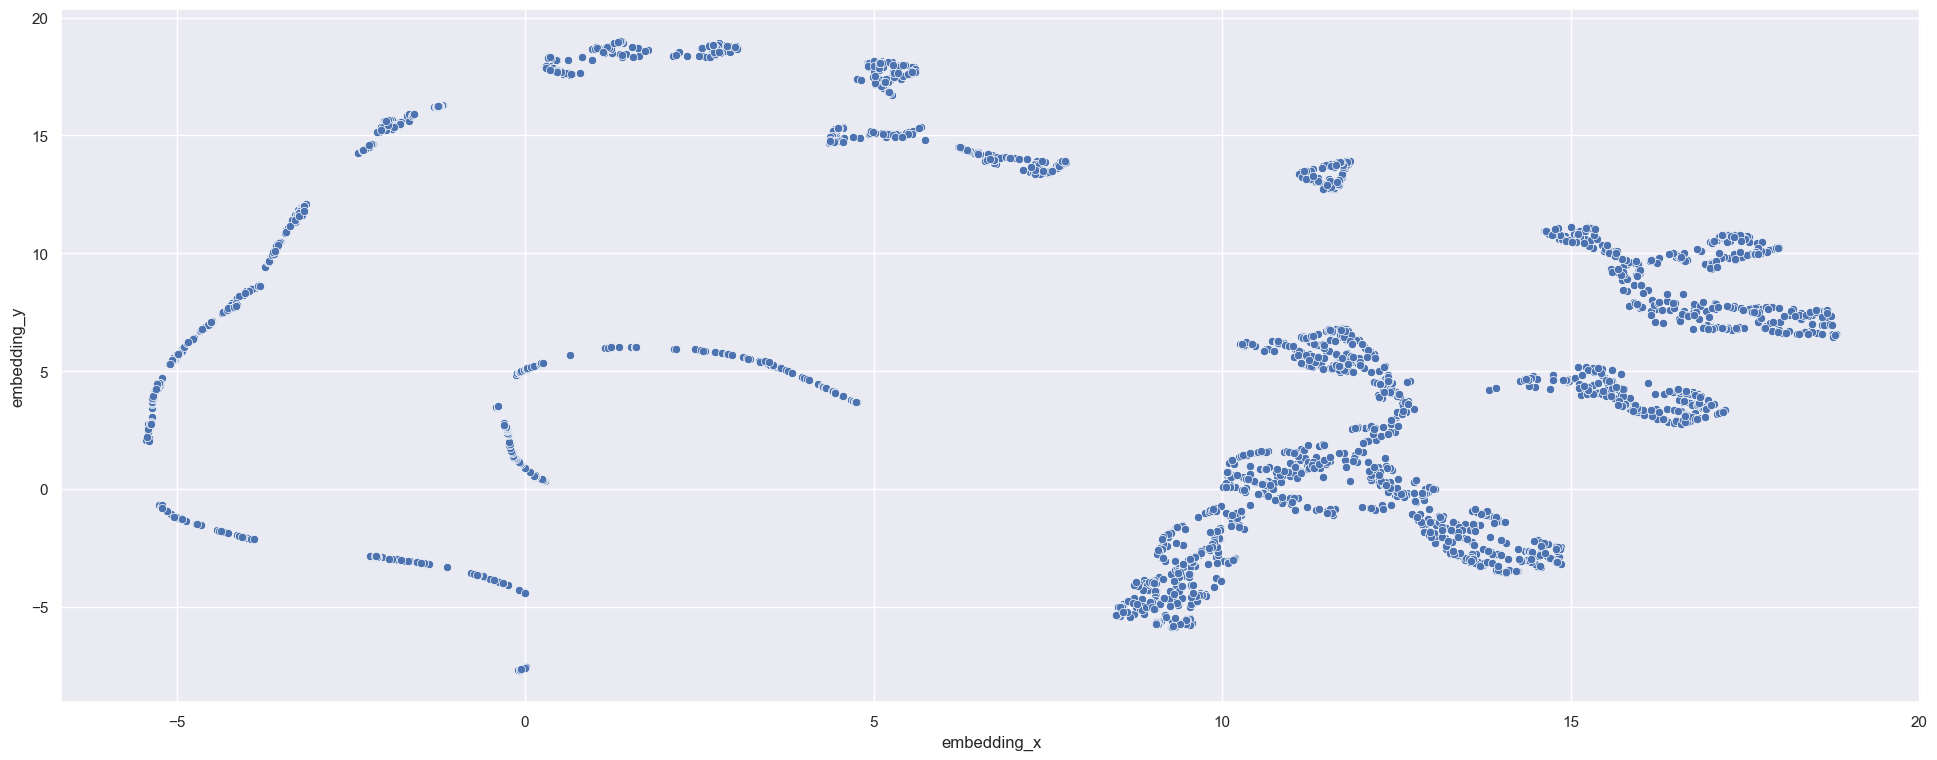

In [52]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap )

# plot UMAP
#sns.scatterplot( x='embedding_x', y='embedding_y', 
#                 hue='cluster', 
#                 palette=sns.color_palette( 'hls', n_colors=len( df_pca['cluster'].unique() ) ),
#                 data=df_umap )

### 4.3.3. t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

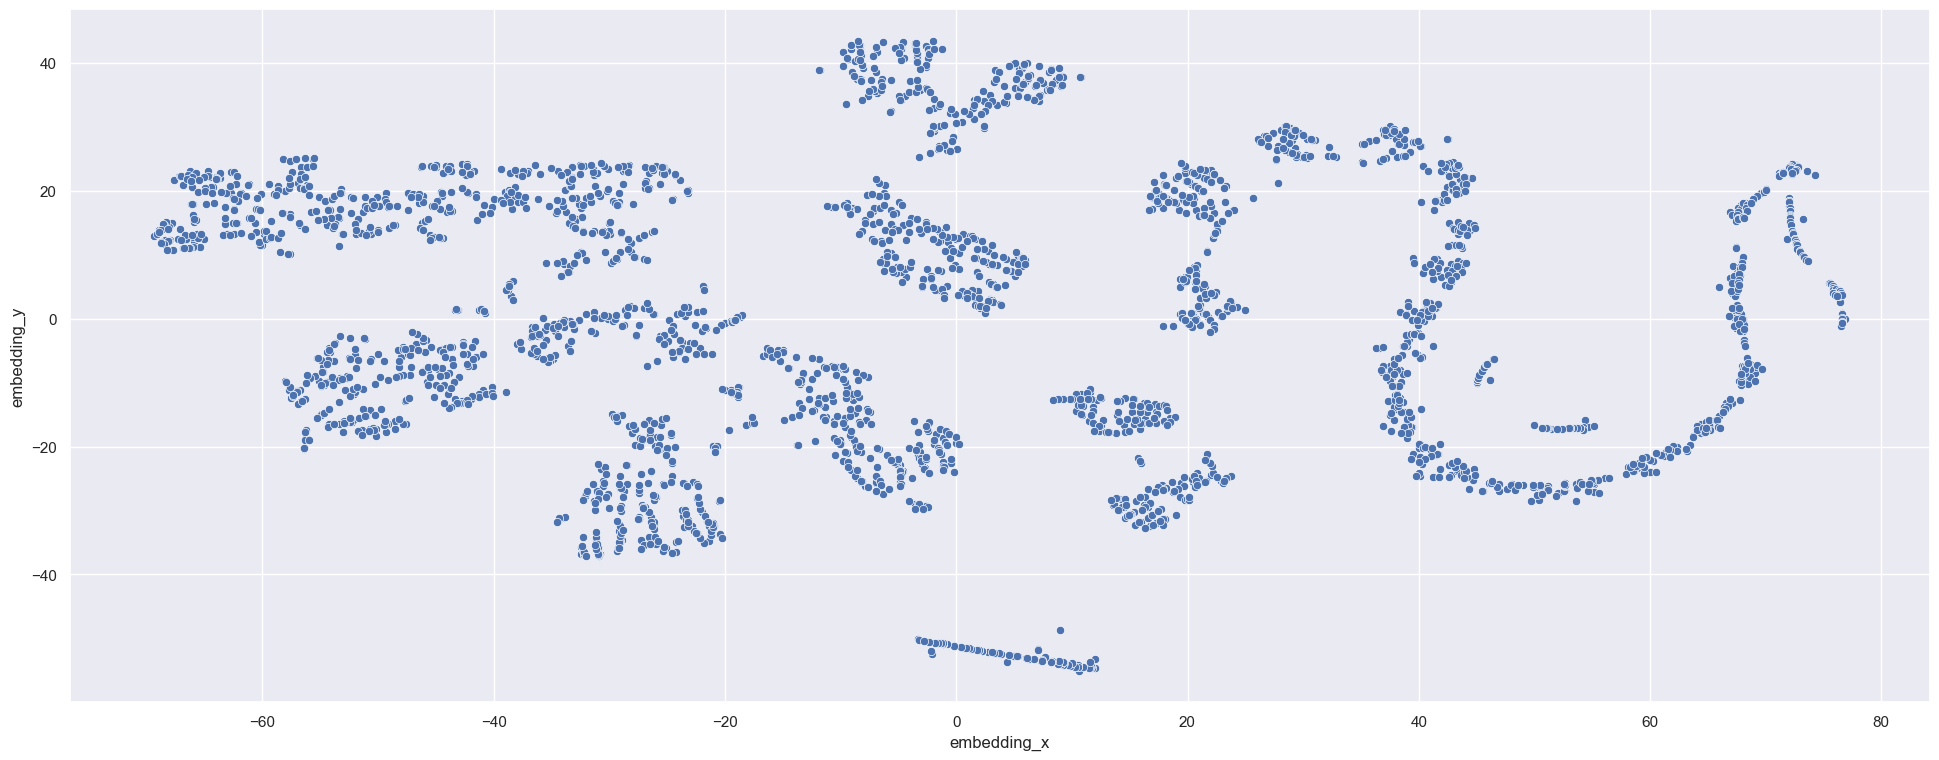

In [53]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne )

### 4.3.4. Tree-Based Embedding

In [54]:
# training dataset
X = df43.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [55]:
df43.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,17850,0.019292,0.997319,0.037770,1.000000,0.004438
1,13047,0.011559,0.150134,0.021692,0.001345,0.003883
2,12583,0.024000,0.005362,0.029476,0.002052,0.005547
3,13748,0.003375,0.254692,0.003445,0.000734,0.000000
4,15100,0.003116,0.892761,0.000255,0.003985,0.002441


C:\Users\nerod\anaconda3\envs\clusterizacao\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

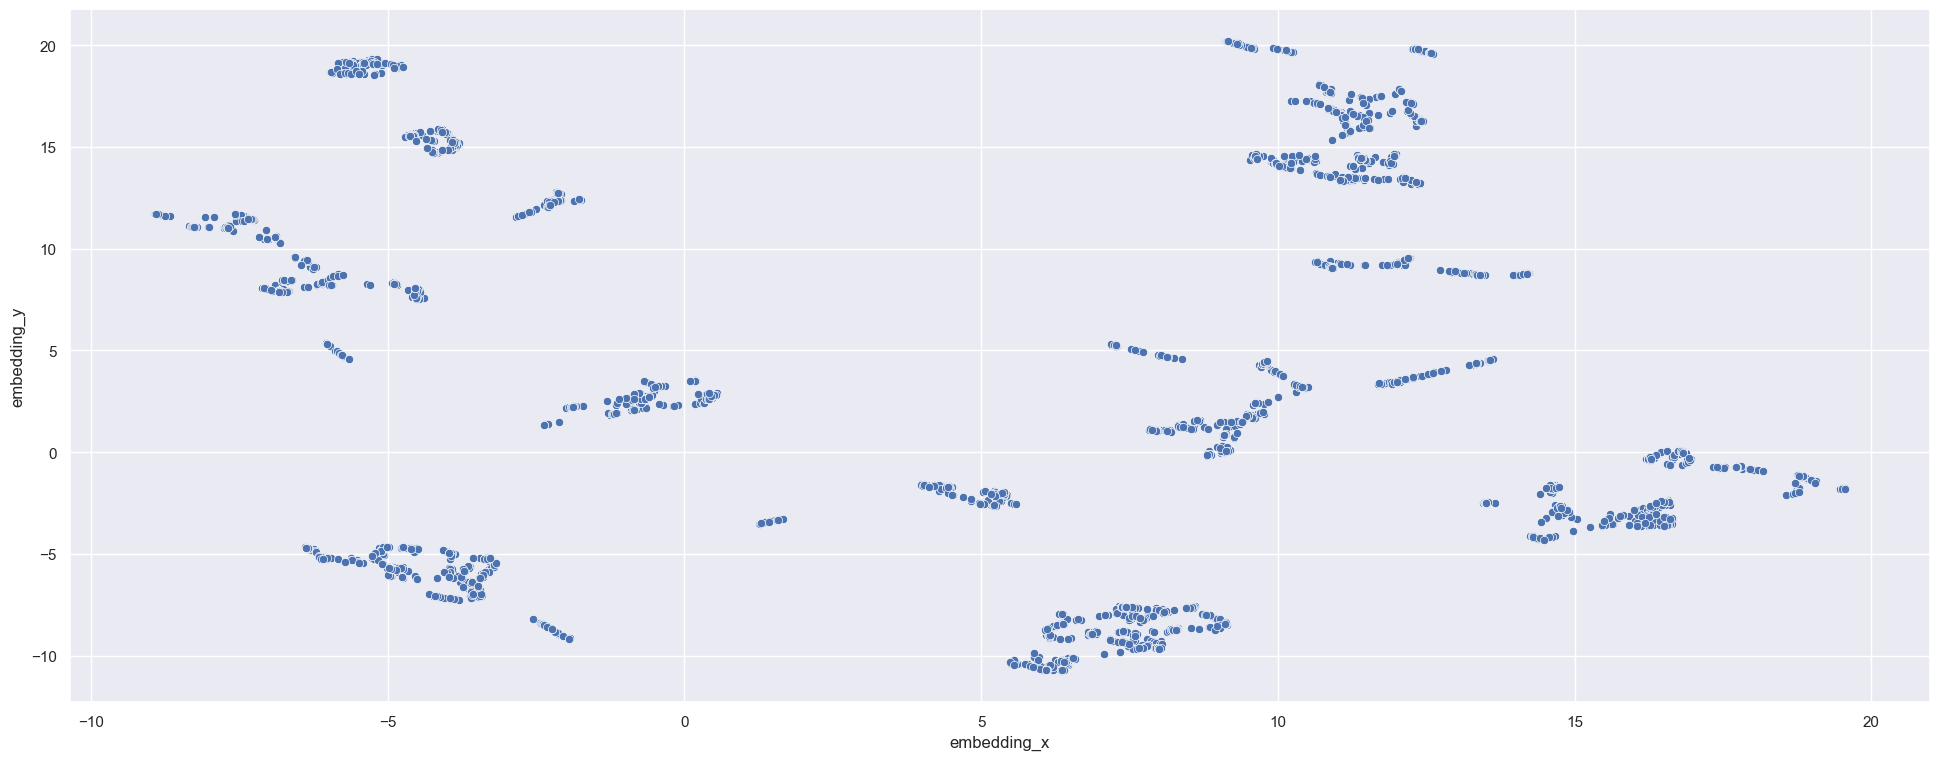

In [56]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# <font color='red'> 5.0. Data Preparation </font>

In [57]:
# Tree-Based Embedding
df5 = df_tree.copy()

# UMAP Embedding
#df5 = df_umap.copy()

# TSNE Embedding
#df5 = df_tsne.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [58]:
X = df5.copy()

In [59]:
X.head()

,embedding_x,embedding_y
0,11.392265,15.986683
1,12.048858,9.246225
2,12.309741,16.534451
3,-0.350943,2.345389
4,-6.207027,9.098992


In [60]:
#clusters = [2, 3, 4, 5, 6, 7, 8, 9]
clusters = np.arange( 2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

## 7.1. K-Means

In [61]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k, n_init=100, random_state=42 )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

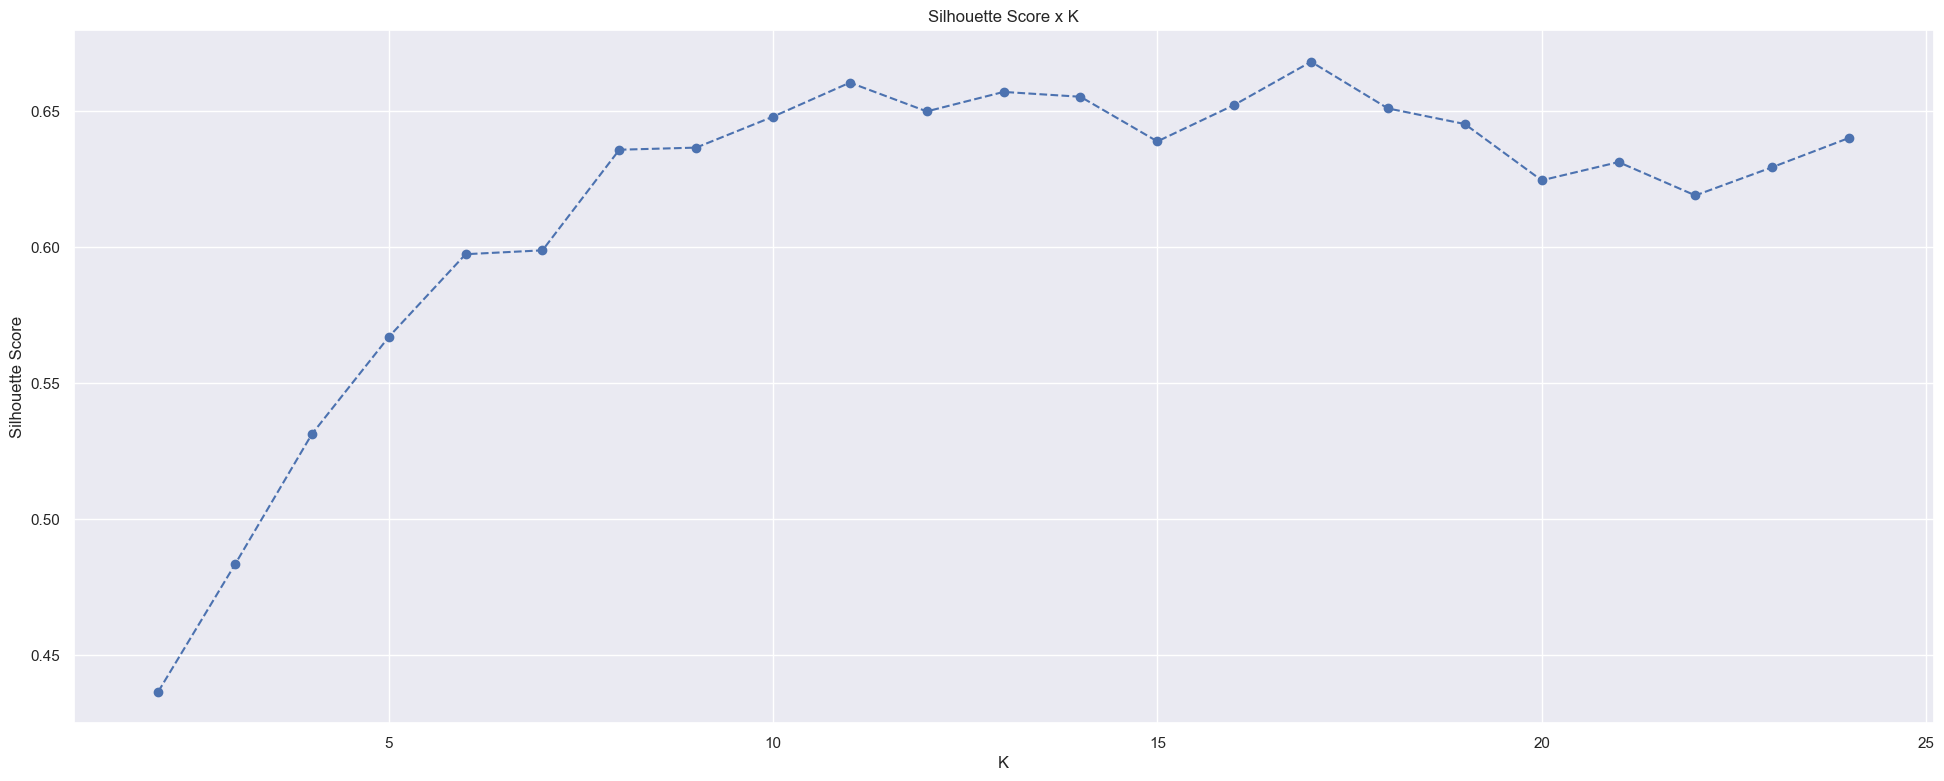

In [62]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2. GMM

In [63]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k, n_init=10, random_state=42, covariance_type='diag' )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

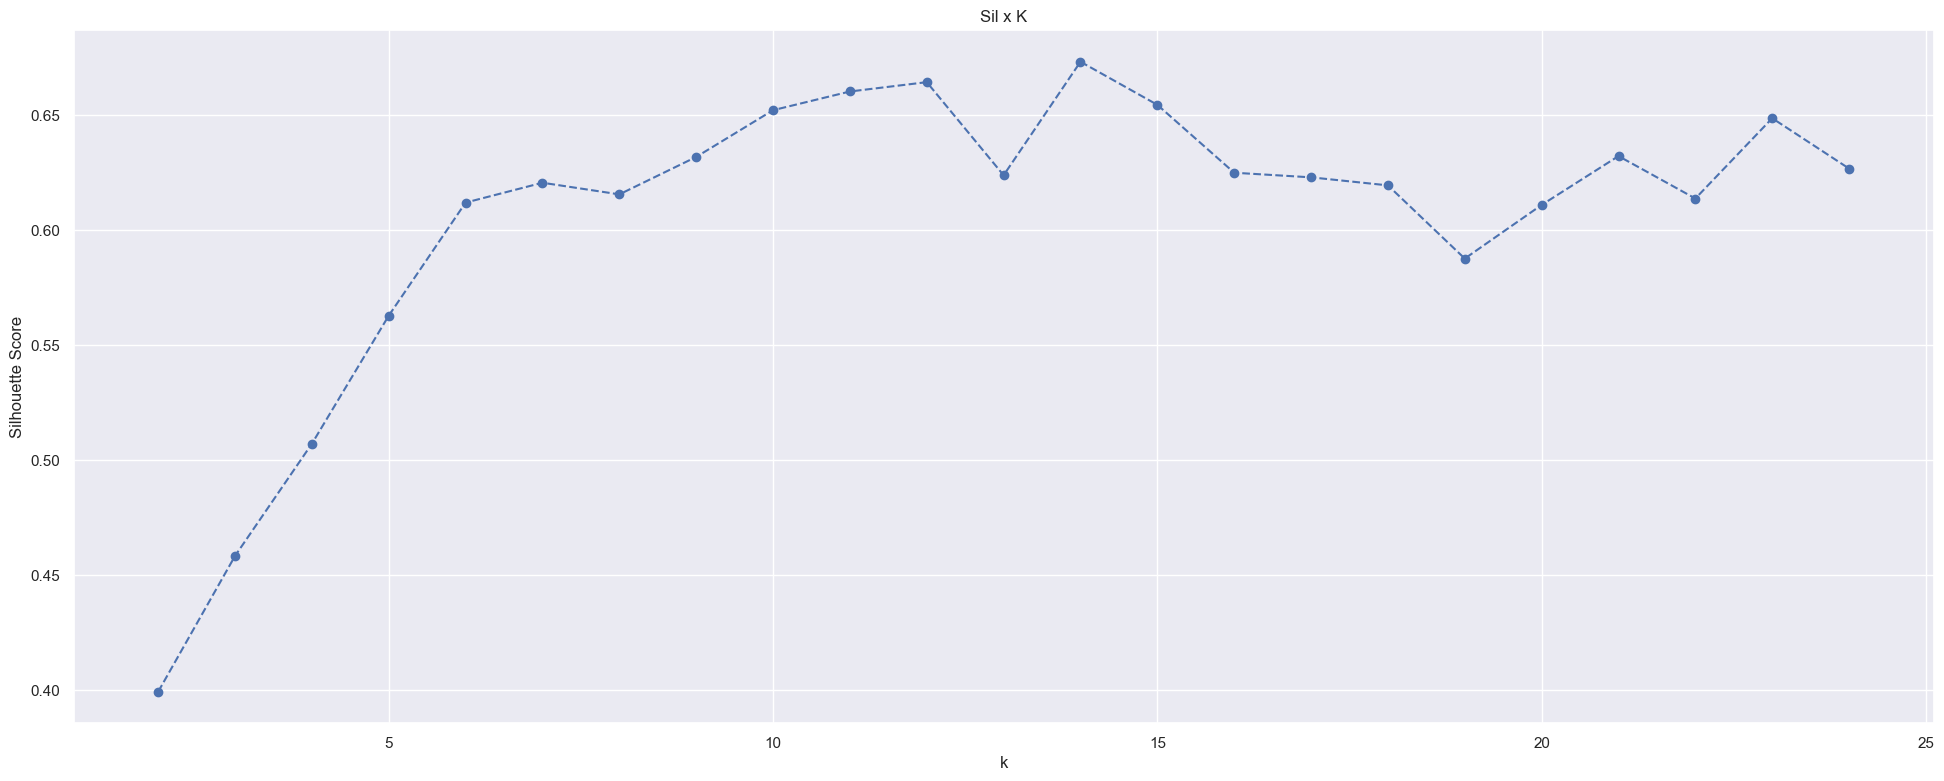

In [64]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3. Hierarchical Clustering

### 7.3.1. HClustering Silhouette Score

In [66]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

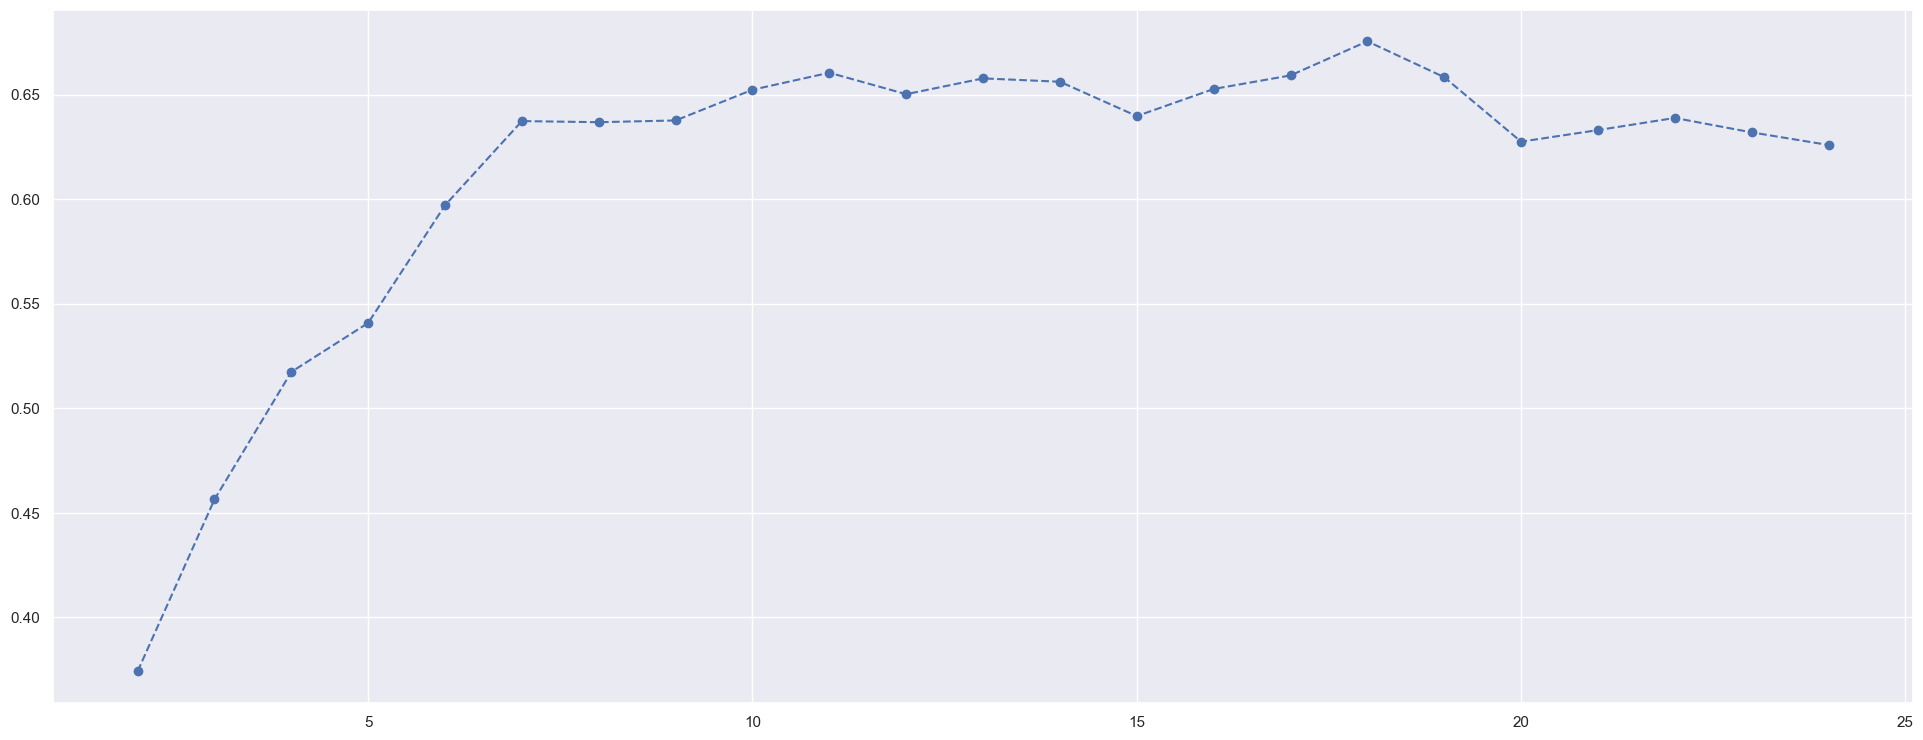

In [67]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

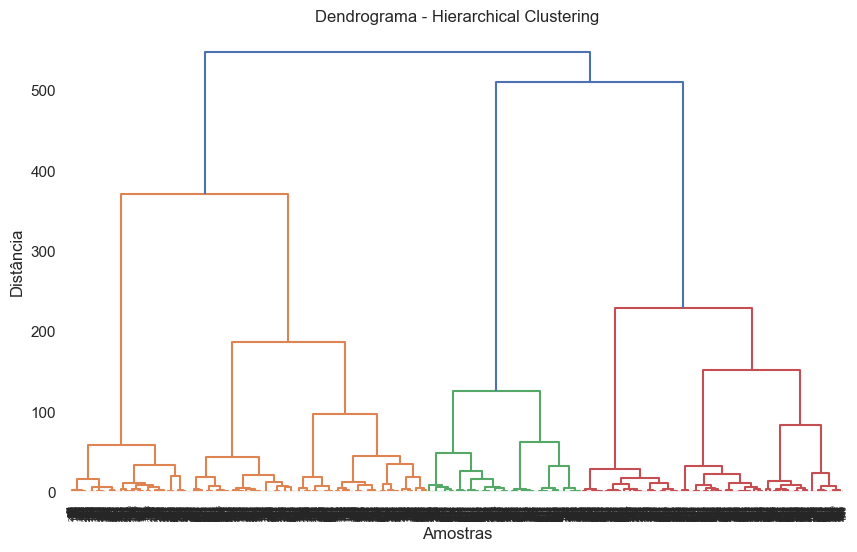

In [68]:
plt.figure(figsize=(10, 6))
hc.dendrogram(hc_model)
plt.title('Dendrograma - Hierarchical Clustering')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.show()

## 7.4. DBSCAN

In [69]:
# Lista de possíveis valores
eps_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
min_samples_list = [3, 5, 10, 15, 20, 25]

# Gera TODAS as combinações possíveis entre eps e min_samples
param_dict = [
    {"eps": e, "min_samples": m}
    for e, m in itertools.product(eps_list, min_samples_list)
]

In [70]:
DBSCAN_list = []
for k in clusters:
#    print(f"\n🔹 Testando cluster {k}")
    
    # Executa 5 vezes, testando combinações diferentes
    for i in range(5):
        params = random.choice(param_dict)
        eps = params["eps"]
        min_samples = params["min_samples"]
        
        # Modelo DBSCAN
        dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
        labels = dbscan_model.fit_predict(X)

        # Verifica se formou mais de 1 cluster
        if len(set(labels)) > 1:
            sil = m.silhouette_score(X, labels, metric='euclidean')
        else:
            sil = np.nan  # evita erro se só houver 1 cluster ou ruído
        # Guarda resultados
        DBSCAN_list.append({
            "cluster": k,
            "eps": eps,
            "min_samples": min_samples,
            "silhouette": sil
        })
        
#        print(f"→ Combinação {i+1}: eps={eps}, min_samples={min_samples}, silhouette={sil:.4f}")

        
#print("\n✅ Testes concluídos!")
#for res in DBSCAN_results[:10]:  # Mostra só os 10 primeiros para não poluir
#    print(res)

In [71]:
best_DBSCAN_end = max(DBSCAN_list, key=lambda x: (x["silhouette"], -x["cluster"]))
print(best_DBSCAN_end )

{'cluster': 3, 'eps': 2.5, 'min_samples': 3, 'silhouette': 0.65866214}


In [72]:
# Efetuar o for com o hiperparametros.

DBSCAN_list_end = []
for k in clusters:
    eps=best_DBSCAN_end ['eps']
    min_samples=best_DBSCAN_end ['min_samples']
    
    # model definition
    dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )
    
    # mode training & predict 
    labels = dbscan_model.fit_predict( X )
    
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    DBSCAN_list_end.append( sil )
    
    
    #print( 'Silhouette Score: {}'.format( sil ) )
    #print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
    #print( unique( labels ) )
    

In [73]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

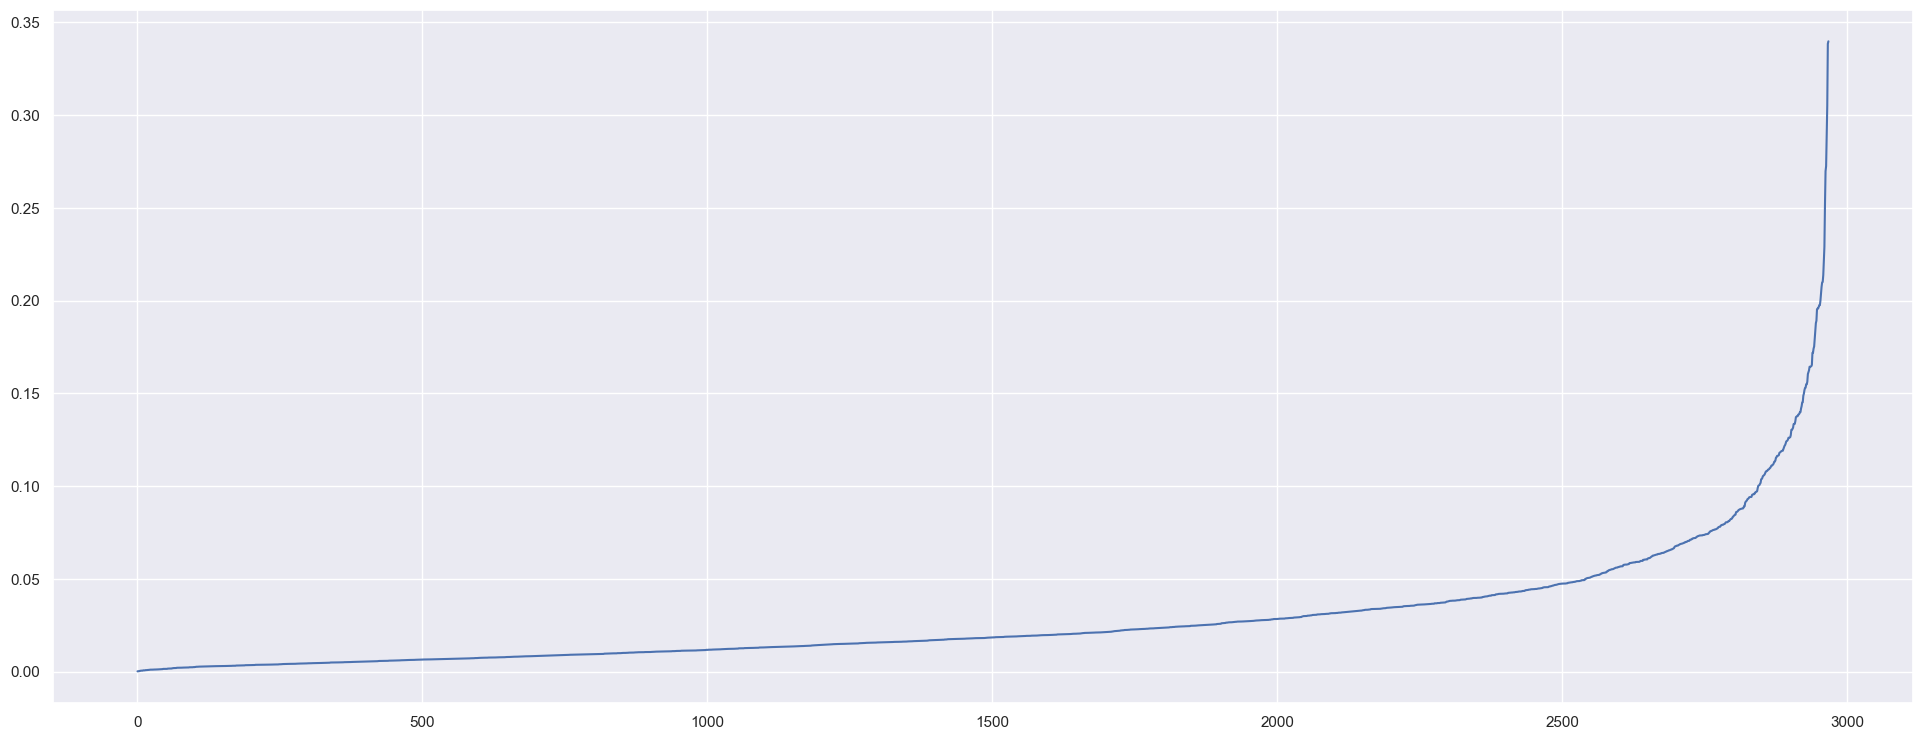

In [74]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

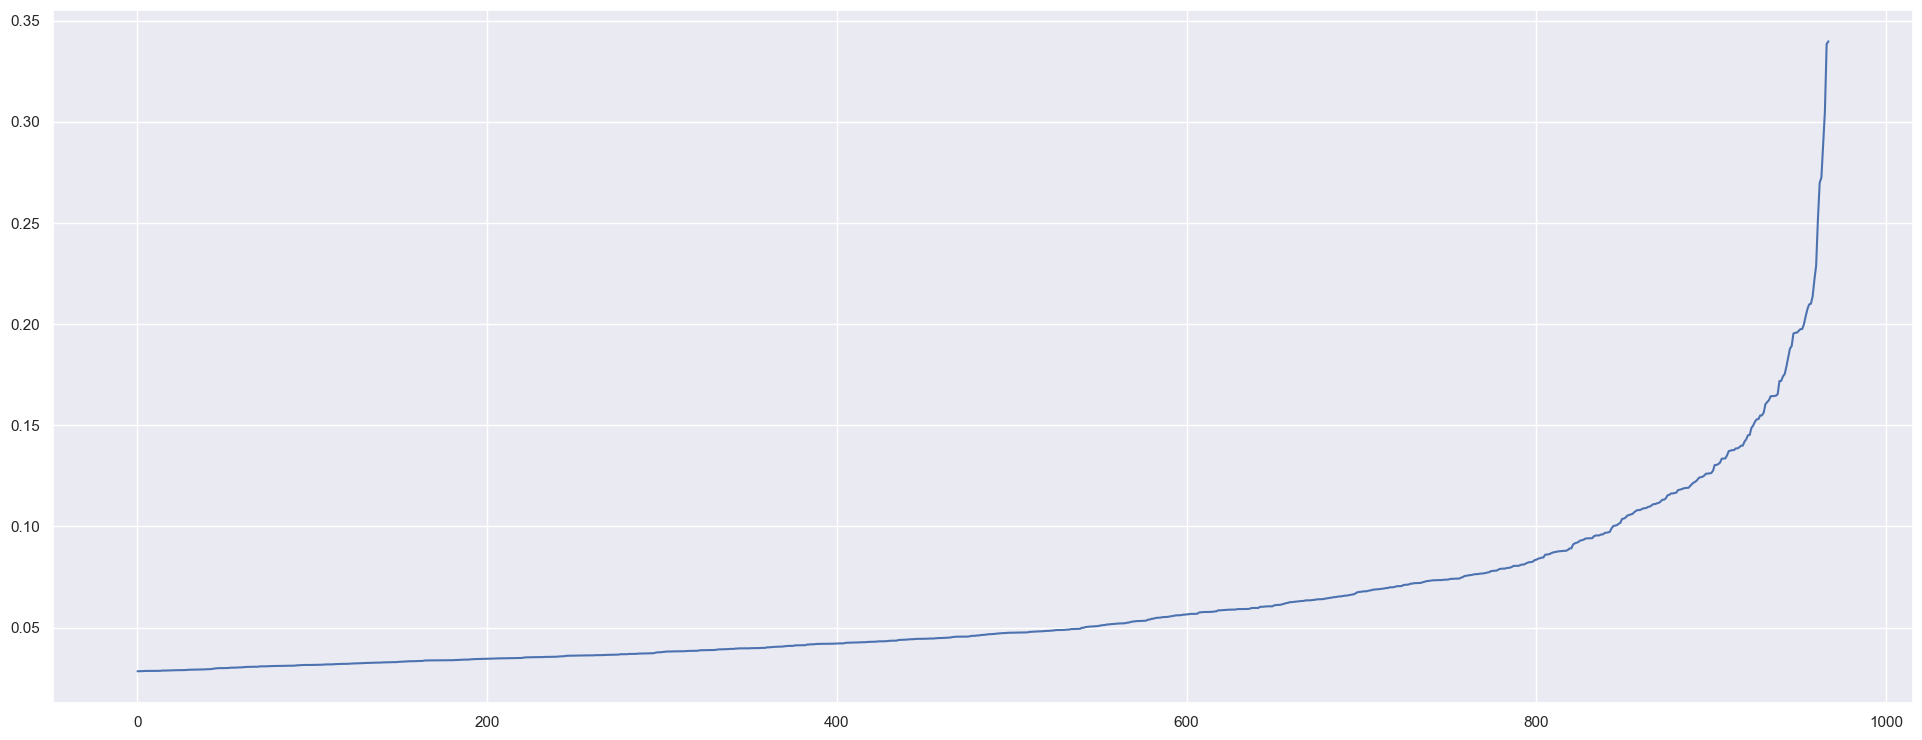

In [75]:
plt.plot( distances[2000:] )

## 7.5. Results

In [76]:
## 7.5. Results - Tree Based Embedding

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list,'DBSCAN': DBSCAN_list_end}).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.436482,0.483312,0.531209,0.566925,0.597359,0.598779,0.635768,0.636549,0.647926,0.660445,0.649863,0.657026,0.655245,0.638831,0.652231,0.668118,0.650963,0.645224,0.624517,0.631223,0.618963,0.629339,0.640113
GMM,0.399234,0.458326,0.507160,0.562902,0.612098,0.620738,0.615676,0.631965,0.652307,0.660445,0.664508,0.623997,0.673390,0.654650,0.625095,0.623090,0.619595,0.587734,0.611079,0.632337,0.613871,0.648811,0.626900
HC,0.374277,0.456421,0.517412,0.540818,0.597091,0.637324,0.636792,0.637629,0.652307,0.660445,0.650185,0.657740,0.656136,0.639715,0.652670,0.659159,0.675465,0.658310,0.627491,0.633014,0.638824,0.631930,0.625893
DBSCAN,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662,0.658662


# <font color='red'> 8.0. Model Training </font>

## 8.1. Final model

In [ ]:
## model definition
#k = 8
#
### model definition
#gmm_model = mx.GaussianMixture( n_components=k, n_init=300, random_state=32 )
#
## model training
#gmm_model.fit( X )
#
## model predict
#labels = gmm_model.predict( X )

In [77]:
# model definition
k = 8

hc_model = hc.linkage( X, 'ward' )

# model predict
labels = hc.fcluster( hc_model, k, criterion='maxclust' )


## 8.2. Cluster Validation

In [78]:
## WSS ( Within-cluster sum of square)
#print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.636792004108429


# <font color='red'> 9.0. Cluster Analysis </font>

In [79]:
df9 = X.copy()
df9['cluster'] = labels

In [80]:
df9.head()

,embedding_x,embedding_y,cluster
0,11.392265,15.986683,1
1,12.048858,9.246225,3
2,12.309741,16.534451,1
3,-0.350943,2.345389,8
4,-6.207027,9.098992,4


## 9.1. Visualization Inspection

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

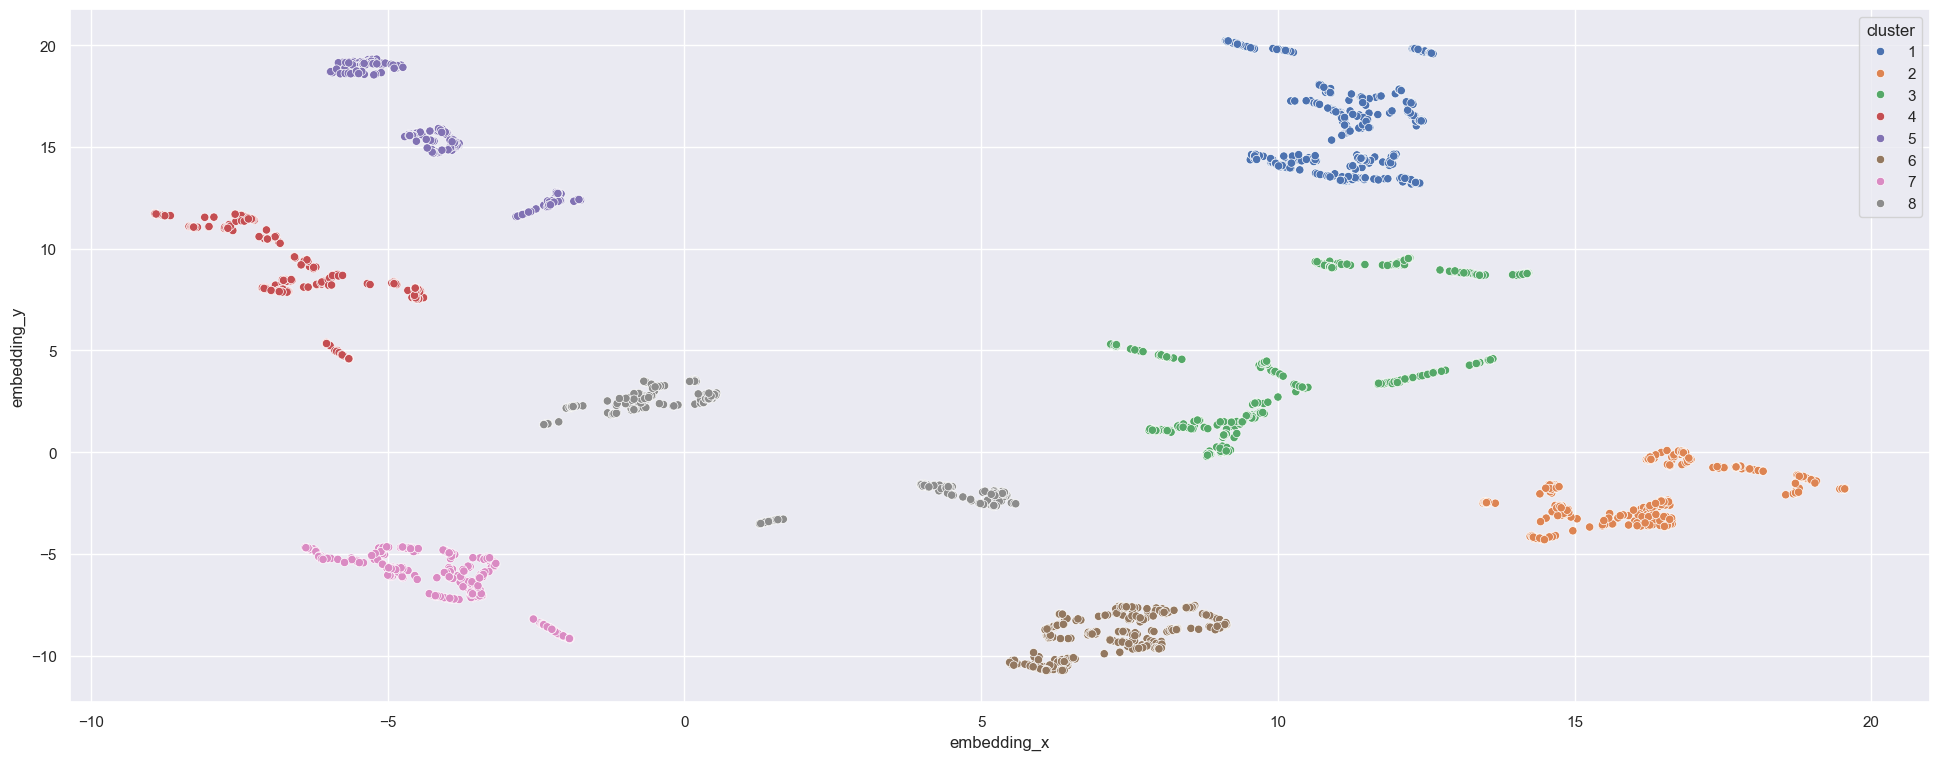

In [81]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

## 9.3. Save models

In [82]:
pasta_pickle = 'C:\\Users\\nerod\\Repos\\DS\\Clusterizacao_git\\pa005_insiders_clustering-master\\pa005_insiders_clustering-master\\insiders_clustering\\models\\pipeline.pkl'

In [84]:
joblib.dump({
    "m1": mm1,
    "m2": mm2,
    "m3": mm3,
    "m4": mm4,
    "m5": mm5,
    "model": hc_model,
    "labels": labels
}, pasta_pickle)

['C:\\Users\\nerod\\Repos\\DS\\Clusterizacao_git\\pa005_insiders_clustering-master\\pa005_insiders_clustering-master\\insiders_clustering\\models\\pipeline.pkl']

## 9.4. Cluster Profile

In [85]:
df92 = df4[ cols_selected ].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,1
1,13047,3232.59,56.0,171.0,0.028302,35.0,3
2,12583,6705.38,2.0,232.0,0.040323,50.0,1
3,13748,948.25,95.0,28.0,0.017921,0.0,8
4,15100,876.00,333.0,3.0,0.073171,22.0,4


In [110]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster.sort_values( 'gross_revenue', ascending=False )

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,1,468,15.768194,8836.136389,21.438034,424.134615,0.094571,149.271368
2,3,502,16.913747,2620.966992,41.444223,141.310757,0.047505,22.595618
7,8,308,10.377358,2467.045292,74.051948,59.165584,0.119591,27.383117
1,2,404,13.611860,1689.182401,54.801980,89.202970,0.050037,11.542079
5,6,372,12.533693,1237.753145,61.282258,54.357527,0.043705,8.771505
6,7,322,10.849057,971.025435,75.329193,37.462733,0.074586,6.571429
4,5,278,9.366577,583.416619,91.064748,11.589928,0.029009,1.003597
3,4,314,10.579515,527.524140,136.035032,16.449045,0.523438,11.439490


In [ ]:
# 1 Cluster Insiders
# 3 Cluster Spend Money
# 8 Cluster More Products
# 2 Cluster Even More Products
# 6 Cluster Less Days
# 7 Cluster Less 1k
# 5 Cluster More Buy
# 4 Cluster Even More Buy

### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 468
    - Faturamento médio: 8836
    - Recência média: 21 dias
    - Média de Produtos comprados: 424 produtos
    - Frequência de compra: 0.09 quant. de compras/dia
    - Receita em média: $8836.13,00 dólares
        
### Cluster 03: 
    - Número de customers: 468
    - Faturamento médio: 8836
    - Recência média: 21 dias
    - Média de Produtos comprados: 424 produtos
    - Frequência de compra: 0.09 quant. de compras/dia
    - Receita em média: $8836.13,00 dólares
        
### Cluster 08: 
    - Número de customers: 468
    - Faturamento médio: 8836
    - Recência média: 21 dias
    - Média de Produtos comprados: 424 produtos
    - Frequência de compra: 0.09 quant. de compras/dia
    - Receita em média: $8836.13,00 dólares

# <font color='red'> 9.5. Base dashboard </font>

In [118]:
df92.to_csv(
    r'C:\Users\nerod\Repos\DS\Clusterizacao_git\pa005_insiders_clustering-master\pa005_insiders_clustering-master\insiders_clustering\data\clientes_clusterizados.csv',
    index=False,
    encoding='utf-8'
)

# <font color='red'> 10.0. Análise Exploratória de Dados </font>

In [88]:
df10 = df92.copy()

In [89]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,1
1,13047,3232.59,56.0,171.0,0.028302,35.0,3
2,12583,6705.38,2.0,232.0,0.040323,50.0,1
3,13748,948.25,95.0,28.0,0.017921,0.0,8
4,15100,876.00,333.0,3.0,0.073171,22.0,4


### H1: **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras**
**Verdade:** O cluster insider possuem um volume de compra de produtos de 54.48%

In [90]:
# soma da qtde de produtos do insiders
df_sales_insiders = df10.loc[df10['cluster'] == 1, 'qtde_products'].sum()
df_sales_total = df10.loc[:, 'qtde_products'].sum()

# soma da qtde de produtos total
print( '% Sales Insiders: {:.2f}%'.format( 100*df_sales_insiders / df_sales_total ) )

% Sales Insiders: 54.48%


### H2. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras**
**Verdadeiro:** O cluster insider possuem um volume de GMV de 51.73%

In [92]:
# soma da qtde de produtos do insiders
df_gmv_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# soma da qtde de produtos total
print( '% GMV Insiders: {:.2f}%'.format( 100*df_gmv_insiders / df_gmv_total ) )

% GMV Insiders: 51.73%


### H3. **Os clientes do cluster insiders tem um número de devolução médio abaixo da média da base total de clientes**
**Falso**: O cluser insiders tem a média de devoluções acima da média geral

In [93]:
# media de devolucao do cluster insider
df_avg_return_insiders = df10.loc[df10['cluster'] == 1, 'qtde_returns'].mean()

# media de devolucao do total
df_avg_return_all = df10['qtde_returns'].mean()

#
print( 'Avg Return Insiders: {} vs Avg Return All:{}'.format( np.round( df_avg_return_insiders, 0 ), 
                                                              np.round( df_avg_return_all, 0 ) ) )

Avg Return Insiders: 149.0 vs Avg Return All:35.0


### H4. **A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a  mediana do faturamento geral.**
**Verdadeiro**. A mediana do faturamento é 276% acima da média.

In [95]:
# mediana de gmv do insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].median()

# mediana de gmv do total
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = ( df_median_gmv_insiders - df_median_gmv_total ) / df_median_gmv_total
print( 'Median Diff: {:.2f}%'.format( 100*gmv_diff ) )

Median Diff: 276.48%


### H5. **A GMV dos clientes insiders esta concentrados no 3 quartil**
**Falso**. O faturamento do cluster insiders está concentrada na quartil 1

In [96]:
np.percentile( df10.loc[df10['cluster'] == 1, 'gross_revenue'], q=0.1 )

617.56155

In [97]:
np.percentile( df10.loc[df10['cluster'] == 1, 'gross_revenue'], q=0.9 )

823.98433

<Axes: xlabel='gross_revenue'>

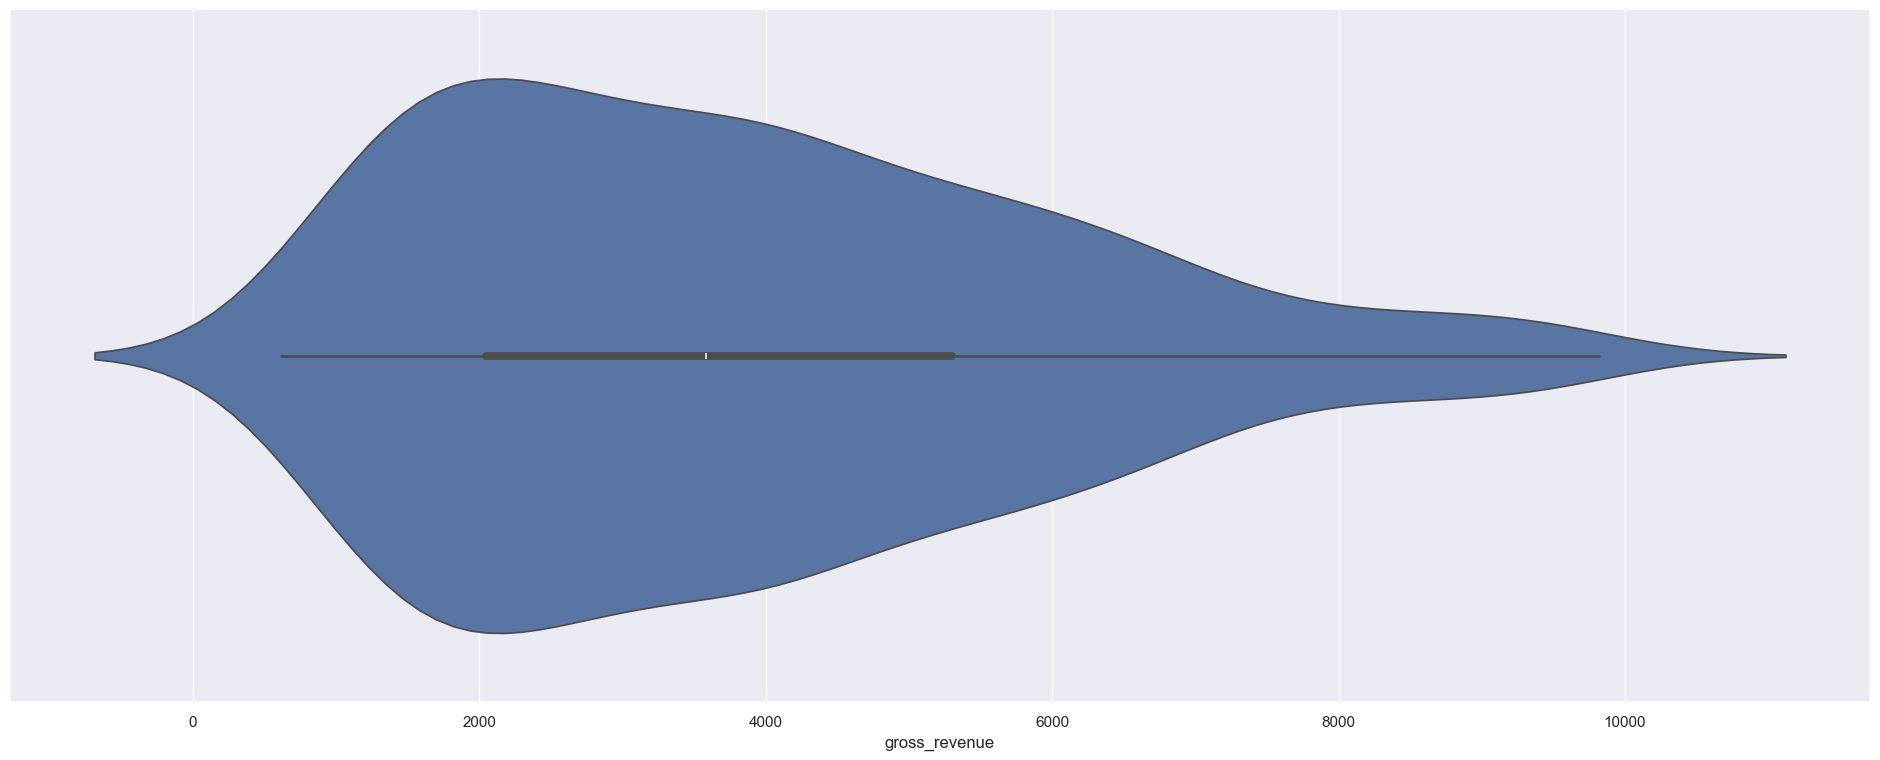

In [99]:
df_aux = df10.loc[(df10['cluster'] == 1) & (df10['gross_revenue'] < 10000 ), 'gross_revenue'];
sns.violinplot( x=df_aux )

# <font color='red'> 11.0. Perguntas de negócio </font>

In [100]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,1
1,13047,3232.59,56.0,171.0,0.028302,35.0,3
2,12583,6705.38,2.0,232.0,0.040323,50.0,1
3,13748,948.25,95.0,28.0,0.017921,0.0,8
4,15100,876.00,333.0,3.0,0.073171,22.0,4


### **1. Quem são as pessoas elegíveis para participar do programa de Insiders ?**

In [103]:
df10.loc[df10['cluster'] == 1, 'customer_id'].head()

0     17850
2     12583
6     14688
8     15311
12    16029
Name: customer_id, dtype: int32

### **2. Quantos clientes farão parte do grupo?**

In [104]:
df10.loc[df10['cluster'] == 1, 'customer_id'].size

468

### 3. Quais as principais características desses clientes ?###

#### Cluster Insider
    - Número de customers: 468 (16% do customers )
    - Faturamento médio: 8836
    - Recência média: 21 dias
    - Média de Produtos comprados: 424 produtos
    - Frequência de Produtos comprados: 0.09 produtos/dia
    - Receita em média: $8836.13,00 dólares

## **4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**

In [109]:
df_insiders_gmv = df10.loc[df10['cluster'] == 1, 'gross_revenue'].sum()
df_all_gmv = df10.loc[:, 'gross_revenue'].sum()

print( '% GMV from Insiders: {}'.format( df_insiders_gmv / df_all_gmv ) )

% GMV from Insiders: 0.5172848940036087


## **5. Quais as condições para uma pessoa ser elegível ao Insiders ?**

- Os critérios básicos para um cliente ser considerado Insider é possuir um gasto médio de igual ou superior a $8836, recência não superior a 21 dias e frequencia média de 0.09 de compras por dia.

## **6. Quais as condições para uma pessoa ser removida do Insiders ?**

- O cliente será retirado do grupo insiders caso não atenda a dois ou mais requisitos exigidos para ser do grupo insiders por mais de 60 dias consecutivos ou reduza o valor médio de gastos para patamares inferiores a $8.835 por 3 meses consecutivos.

## **7. Quais ações o time de marketing pode realizar para aumentar o faturamento?**

O marketing deverá direcionar esforços para incentivar os clientes dos demais clusters a se aproximarem do comportamento de compra do grupo Insiders. Para isso, é essencial implementar estratégias que aumentem o ticket médio, reduzam o tempo de recência e estimulem a frequência de compra.

Essas ações devem ser personalizadas conforme o perfil de cada cluster, promovendo experiências relevantes e fortalecendo o relacionamento com a marca.

1. Receita / Ticket Médio (aumentar o valor gasto por compra):

 - Cross-sell e upsell inteligentes: sugerir itens complementares ou de categoria superior no carrinho.

 - Bundles promocionais: descontos em combos de produtos ou kits de marcas parceiras.

 - Frete grátis acima de determinado valor: estimular aumento do carrinho médio.

 - Criação de grupos intermediários ao grupo Insiders: Criar grupos intermediários com ofertas e serviços VIP que aumentam a cada elevação de grupo.
 
2. Frequência (aumentar o número de compras por cliente):

 - Programa de fidelidade com benefícios progressivos: pontos, cashback ou acesso antecipado a promoções.

 - Assinaturas de produtos recorrentes (ex.: básicos de vestuário, perfumes, acessórios).

 - Campanhas de “compre e ganhe”: recompensas por volume ou frequência de compras.

 - Ações de gamificação: desafios mensais (“compre 3 vezes e ganhe um brinde”).

 - Segmentação por comportamento: recomendações automáticas com base em histórico de navegação e categorias preferidas.
 
3. Recência (diminuir o tempo entre a última e a próxima compra):

 - Campanhas de reativação segmentadas: e-mails e SMS com ofertas exclusivas para clientes inativos há 30, 60 e 90 dias.

 - Retargeting personalizado: anúncios dinâmicos exibindo produtos visualizados recentemente ou similares.

 - Push notifications de novidades: destacar novas coleções ou lançamentos das marcas favoritas.

 - Cupons de “boas-vindas de volta”: incentivo com prazo curto para recompra.

 - Fluxo automatizado de remarketing pós-compra: enviar lembrete de produtos complementares após um período determinado.